In [8]:
from absl import logging
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import collections
import numpy as np
import tensorflow.keras.layers as layers
from tqdm import tqdm

import io
import tifffile
import quilt3 as q3

In [9]:
list(q3.list_packages("s3://allencell"))

['aics/actk',
 'aics/aics_mnist',
 'aics/cell_line_exomes',
 'aics/cell_line_rnaseq',
 'aics/data_handoff_4dn',
 'aics/hipsc_12x_overview_image_dataset',
 'aics/hipsc_single_cell_image_dataset',
 'aics/hipsc_single_cell_image_dataset_supp_myh10',
 'aics/hipsc_single_edge_cell_image_dataset',
 'aics/hipsc_single_i1_cell_image_dataset',
 'aics/hipsc_single_i2_cell_image_dataset',
 'aics/hipsc_single_m1_cell_image_dataset',
 'aics/hipsc_single_m2_cell_image_dataset',
 'aics/hipsc_single_nonedge_cell_image_dataset',
 'aics/integrated_transcriptomics_structural_organization_hipsc_cm',
 'aics/label-free-imaging-collection',
 'aics/laminb1_sample_data',
 'aics/mitotic_annotation',
 'aics/nuclear_project_dataset_1',
 'aics/nuclear_project_dataset_2',
 'aics/nuclear_project_dataset_3',
 'aics/nuclear_project_dataset_4',
 'aics/pipeline_integrated_cell',
 'aics/pipeline_integrated_single_cell',
 'aics/segmenter_model_zoo',
 'aics/wtc11_hipsc_cardiomyocyte_scrnaseq_d0_to_d90',
 'aics/wtc11_linked

In [7]:
label_free = q3.Package.browse(
    "aics/label-free-imaging-collection",
    registry="s3://allencell"
)

Loading manifest: 100%|█████████████████████| 49342/49342 [00:00<00:00, 95.3k/s]


In [39]:
imread_bytes = lambda b: tifffile.TiffFile(io.BytesIO(b)).asarray()
img = label_free["cells_2d"]["fov-0_CellIndex-12.tiff"](imread_bytes)

In [41]:
single_cell = q3.Package.browse(
    "aics/hipsc_single_cell_image_dataset",
    registry="s3://allencell"
)

Loading manifest: 100%|███████████████████| 484465/484465 [00:07<00:00, 67.4k/s]


In [44]:
img = single_cell["crop_raw"]["00011451c65b106cf9889bbf78cb4aa2cf2f9ec56c681e50fafc9635c3abf752_raw.ome.tif"](imread_bytes)

In [43]:
single_cell["crop_raw"]

(remote Package)
 └─00011451c65b106cf9889bbf78cb4aa2cf2f9ec56c681e50fafc9635c3abf752_raw.ome.tif
 └─000136c32c54c3b33df562be1b916e2cab0d8437300f518866e6c03610750537_raw.ome.tif
 └─000140defc56a56ebee268271d648f24d46063027820245958398f0624fcdcf1_raw.ome.tif
 └─000154c959b7e87877adc131cf39b11a5796bc4acea133ce1f3eac41644ca151_raw.ome.tif
 └─0001c532d46d0e30e12de1309a1818db5e8cd3b144f4045f36482576516d7d83_raw.ome.tif
 └─00023fa497761bbbd6b6d84f5a36f1e01657c6ef6bfff133d1793491f7608bb6_raw.ome.tif
 └─00025dc4c230e2127264cfc7d185214f984dfd96c3c91e710952fe28ff6a378d_raw.ome.tif
 └─0002640e3a5b33df576a073a911ed32b9049e58a3e8ec612702798b6ac8ce128_raw.ome.tif
 └─00026e522e6d632e983b578eeee9d0ad46b7d6f36efd4b6a840387f8a765e917_raw.ome.tif
 └─0002c87bd63e09cbf5ff08d4a166af65992a8fba86a3df0f56c3b92ab38b20c1_raw.ome.tif
 └─0002f8ddaabd5e9aba9691a242c68b1ff93a708cb0e7c50df56f40ae2721cacb_raw.ome.tif
 └─00034a489693ec3e18f2aaffc50a1cdf01d8a055059fc55e6447aebdb1b4cd99_raw.ome.tif
 └─0003554ed3b1cf872bc8

In [45]:
img.shape

(108, 3, 274, 297)

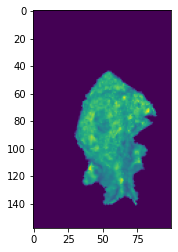

In [36]:
plt.imshow(img[2][0])

In [2]:
def preprocess_clevr(features, resolution, apply_crop=False,
                     get_properties=True, max_n_objects=10):
  """Preprocess CLEVR."""
  image = tf.cast(features["image"], dtype=tf.float32)
  image = ((image / 255.0) - 0.5) * 2.0  # Rescale to [-1, 1].

  image = tf.image.resize(
      image, resolution, method=tf.image.ResizeMethod.BILINEAR)
  image = tf.clip_by_value(image, -1., 1.)
    
  features = {"image": image}
  return features


def build_clevr(split, resolution=(128, 128), shuffle=False, max_n_objects=10,
                num_eval_examples=512, apply_crop=False):
  """Build CLEVR dataset."""
  if split == "train" or split == "train_eval":
    ds = tfds.load("clevr:3.1.0", split="train", shuffle_files=shuffle)
    if split == "train":
      ds = ds.skip(num_eval_examples)
    elif split == "train_eval":
      # Instead of taking the official validation split, we take a smaller split
      # from the training dataset to monitor AP scores during training.
      ds = ds.take(num_eval_examples)
  else:
    ds = tfds.load("clevr:3.1.0", split=split, shuffle_files=shuffle)

  def _preprocess_fn(x, resolution, max_n_objects=max_n_objects):
    return preprocess_clevr(
        x, resolution, apply_crop=apply_crop, get_properties=get_properties,
        max_n_objects=max_n_objects)
  ds = ds.map(lambda x: _preprocess_fn(x, resolution))
  return ds


def build_clevr_iterator(batch_size, split, **kwargs):
  ds = build_clevr(split=split, **kwargs)
  ds = ds.repeat(-1)
  ds = ds.batch(batch_size, drop_remainder=True)
  return iter(ds)

In [3]:
"""Slot Attention model for object discovery and set prediction."""

class SlotAttention(layers.Layer):
  """Slot Attention module."""

  def __init__(self, num_iterations, num_slots, slot_size, mlp_hidden_size,
               epsilon=1e-8):
    """Builds the Slot Attention module.
    Args:
      num_iterations: Number of iterations.
      num_slots: Number of slots.
      slot_size: Dimensionality of slot feature vectors.
      mlp_hidden_size: Hidden layer size of MLP.
      epsilon: Offset for attention coefficients before normalization.
    """
    super().__init__()
    self.num_iterations = num_iterations
    self.num_slots = num_slots
    self.slot_size = slot_size
    self.mlp_hidden_size = mlp_hidden_size
    self.epsilon = epsilon

    self.norm_inputs = layers.LayerNormalization()
    self.norm_slots = layers.LayerNormalization()
    self.norm_mlp = layers.LayerNormalization()

    # Parameters for Gaussian init (shared by all slots).   # Intialize slots randomly at first 
    self.slots_mu = self.add_weight(
        initializer="glorot_uniform",
        shape=[1, 1, self.slot_size],   # slot_size: Dimensionality of slot feature vectors.
        dtype=tf.float32,
        name="slots_mu")
    self.slots_log_sigma = self.add_weight(
        initializer="glorot_uniform",
        shape=[1, 1, self.slot_size],
        dtype=tf.float32,
        name="slots_log_sigma")

    # Linear maps for the attention module.
    self.project_q = layers.Dense(self.slot_size, use_bias=False, name="q")
    self.project_k = layers.Dense(self.slot_size, use_bias=False, name="k")
    self.project_v = layers.Dense(self.slot_size, use_bias=False, name="v")

    # Slot update functions.
    self.gru = layers.GRUCell(self.slot_size)
    self.mlp = tf.keras.Sequential([
        layers.Dense(self.mlp_hidden_size, activation="relu"),
        layers.Dense(self.slot_size)
    ], name="mlp")

  def call(self, inputs):
    # `inputs` has shape [batch_size, num_inputs, inputs_size].
    inputs = self.norm_inputs(inputs)  # Apply layer norm to the input.
    k = self.project_k(inputs)  # Shape: [batch_size, num_inputs, slot_size].  # create key vectors (based on inputs)
    v = self.project_v(inputs)  # Shape: [batch_size, num_inputs, slot_size].  # create value vectors (based on inputs)

    # Initialize the slots. Shape: [batch_size, num_slots, slot_size].
    slots = self.slots_mu + tf.exp(self.slots_log_sigma) * tf.random.normal(
        [tf.shape(inputs)[0], self.num_slots, self.slot_size])  # size: [batch_size, num_slots, slot_size]

    # Multiple rounds of attention.
    for _ in range(self.num_iterations):
      slots_prev = slots
      slots = self.norm_slots(slots)

      # Attention.
      q = self.project_q(slots)  # Shape: [batch_size, num_slots, slot_size].  # create query vectors (based on slots)
      q *= self.slot_size ** -0.5  # Normalization.
      attn_logits = tf.keras.backend.batch_dot(k, q, axes=-1) # Batchwise dot product.
      attn = tf.nn.softmax(attn_logits, axis=-1)
      # `attn` has shape: [batch_size, num_inputs, num_slots]. 
      # attn represents how much attention each slot should pay to the features 

      # Weigted mean.
      attn += self.epsilon
      attn /= tf.reduce_sum(attn, axis=-2, keepdims=True) # summation; sum across the batch_size 
      updates = tf.keras.backend.batch_dot(attn, v, axes=-2)
      # `updates` has shape: [batch_size, num_slots, slot_size].

      # Slot update.
      slots, _ = self.gru(updates, [slots_prev])   # output after gru has shape: [batch_size, num_slots, slot_size]
      slots += self.mlp(self.norm_mlp(slots))      # # output after mlp has shape: [batch_size, num_slots, slot_size]

    return slots


def spatial_broadcast(slots, resolution):
  """Broadcast slot features to a 2D grid and collapse slot dimension."""
  # `slots` has shape: [batch_size, num_slots, slot_size].
  slots = tf.reshape(slots, [-1, slots.shape[-1]])[:, None, None, :]
  grid = tf.tile(slots, [1, resolution[0], resolution[1], 1])   # this operation creates a new tensor by replicating input multiples times
  # `grid` has shape: [batch_size*num_slots, width, height, slot_size].
  return grid


def spatial_flatten(x):
  return tf.reshape(x, [-1, x.shape[1] * x.shape[2], x.shape[-1]])


def unstack_and_split(x, batch_size, num_channels=3):
  """Unstack batch dimension and split into channels and alpha mask."""
  unstacked = tf.reshape(x, [batch_size, -1] + x.shape.as_list()[1:])
  channels, masks = tf.split(unstacked, [num_channels, 1], axis=-1)
  return channels, masks


class SlotAttentionAutoEncoder(layers.Layer):
  """Slot Attention-based auto-encoder for object discovery."""

  def __init__(self, resolution, num_slots, num_iterations):
    """Builds the Slot Attention-based auto-encoder.
    Args:
      resolution: Tuple of integers specifying width and height of input image.
      num_slots: Number of slots in Slot Attention.
      num_iterations: Number of iterations in Slot Attention.
    """
    super().__init__()
    self.resolution = resolution
    self.num_slots = num_slots
    self.num_iterations = num_iterations

    self.encoder_cnn = tf.keras.Sequential([
        layers.Conv2D(64, kernel_size=5, padding="SAME", activation="relu"),
        # kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. 
        # Can be a single integer to specify the same value for all spatial dimensions.
        layers.Conv2D(64, kernel_size=5, padding="SAME", activation="relu"),
        layers.Conv2D(64, kernel_size=5, padding="SAME", activation="relu"),
        layers.Conv2D(64, kernel_size=5, padding="SAME", activation="relu")
    ], name="encoder_cnn")

    self.decoder_initial_size = (8, 8)
    self.decoder_cnn = tf.keras.Sequential([
        layers.Conv2DTranspose(
            64, 5, strides=(2, 2), padding="SAME", activation="relu"),  # filters = 64 (number of output channels); kernel_size = 5 (specify the height and width of the 2D convolution window)
        layers.Conv2DTranspose(
            64, 5, strides=(2, 2), padding="SAME", activation="relu"),
        layers.Conv2DTranspose(
            64, 5, strides=(2, 2), padding="SAME", activation="relu"),
        layers.Conv2DTranspose(
            64, 5, strides=(2, 2), padding="SAME", activation="relu"),
        layers.Conv2DTranspose(
            64, 5, strides=(1, 1), padding="SAME", activation="relu"),
        layers.Conv2DTranspose(
            4, 3, strides=(1, 1), padding="SAME", activation=None)
    ], name="decoder_cnn")

    self.encoder_pos = SoftPositionEmbed(64, self.resolution)
    self.decoder_pos = SoftPositionEmbed(64, self.decoder_initial_size)

    self.layer_norm = layers.LayerNormalization()
    self.mlp = tf.keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64)
    ], name="feedforward")

    self.slot_attention = SlotAttention(
        num_iterations=self.num_iterations,
        num_slots=self.num_slots,
        slot_size=64,
        mlp_hidden_size=128)

  def call(self, image):
    # `image` has shape: [batch_size, width, height, num_channels].

    # Convolutional encoder with position embedding.
    x = self.encoder_cnn(image)  # CNN Backbone.
    x = self.encoder_pos(x)  # Position embedding.
    x = spatial_flatten(x)  # Flatten spatial dimensions (treat image as set).
    x = self.mlp(self.layer_norm(x))  # Feedforward network on set.
    # `x` has shape: [batch_size, width*height, input_size(64)].

    # Slot Attention module.
    slots = self.slot_attention(x)
    # `slots` has shape: [batch_size, num_slots, slot_size].

    # Spatial broadcast decoder.
    x = spatial_broadcast(slots, self.decoder_initial_size)
    # `x` has shape: [batch_size*num_slots, width_init, height_init, slot_size].
    x = self.decoder_pos(x)
    x = self.decoder_cnn(x)
    # `x` has shape: [batch_size*num_slots, width, height, num_channels+1].

    # Undo combination of slot and batch dimension; split alpha masks.
    recons, masks = unstack_and_split(x, batch_size=image.shape[0])
    # `recons` has shape: [batch_size, num_slots, width, height, num_channels].
    # `masks` has shape: [batch_size, num_slots, width, height, 1].

    # Normalize alpha masks over slots.
    masks = tf.nn.softmax(masks, axis=1)
    recon_combined = tf.reduce_sum(recons * masks, axis=1)  # Recombine image.
    # `recon_combined` has shape: [batch_size, width, height, num_channels].

    return recon_combined, recons, masks, slots
    

def build_grid(resolution):
  ranges = [np.linspace(0., 1., num=res) for res in resolution]
  grid = np.meshgrid(*ranges, sparse=False, indexing="ij")
  grid = np.stack(grid, axis=-1)
  grid = np.reshape(grid, [resolution[0], resolution[1], -1])
  grid = np.expand_dims(grid, axis=0)
  grid = grid.astype(np.float32)
  return np.concatenate([grid, 1.0 - grid], axis=-1)


class SoftPositionEmbed(layers.Layer):
  """Adds soft positional embedding with learnable projection."""

  def __init__(self, hidden_size, resolution):
    """Builds the soft position embedding layer.
    Args:
      hidden_size: Size of input feature dimension.
      resolution: Tuple of integers specifying width and height of grid.
    """
    super().__init__()
    self.dense = layers.Dense(hidden_size, use_bias=True)
    self.grid = build_grid(resolution)

  def call(self, inputs):
    return inputs + self.dense(self.grid)


def build_model(resolution, batch_size, num_slots, num_iterations,
                num_channels=3, model_type="object_discovery"):
  """Build keras model."""
  if model_type == "object_discovery":
    model_def = SlotAttentionAutoEncoder
  else:
    raise ValueError("Invalid name for model type.")

  image = tf.keras.Input(list(resolution) + [num_channels], batch_size) # shape = list(resolution) + [num_channels]
  outputs = model_def(resolution, num_slots, num_iterations)(image)  # initialize + call
  model = tf.keras.Model(inputs=image, outputs=outputs)
  return model

In [4]:
"""Training loop for object discovery with Slot Attention."""

# We use `tf.function` compilation to speed up execution. For debugging,
# consider commenting out the `@tf.function` decorator.


def l2_loss(prediction, target):
  return tf.reduce_mean(tf.math.squared_difference(prediction, target))


@tf.function
def train_step(batch, model, optimizer):
  """Perform a single training step."""

  # Get the prediction of the models and compute the loss.
  with tf.GradientTape() as tape:
    preds = model(batch["image"], training=True)
    recon_combined, recons, masks, slots = preds
    loss_value = l2_loss(recon_combined, batch["image"])
    del recons, masks, slots  # Unused.

  # Get and apply gradients.
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))   

  return loss_value

In [5]:
def visualize_loss(losses): 
    """
    Uses Matplotlib to visualize the losses of our model.
    :param losses: list of loss data stored from train. Can use the model's loss_list 
    field 

    NOTE: DO NOT EDIT

    :return: doesn't return anything, a plot should pop-up 
    """
    x = [i for i in range(len(losses))]
    plt.plot(x, losses)
    plt.title('Loss per epoch')
    plt.xlabel('Training Epoch')
    plt.ylabel('Loss')
    plt.show() 

In [ ]:
# Hyperparameters of the model.
batch_size = 64
num_slots = 7
num_iterations = 3
base_learning_rate = 0.0004
num_train_steps = 5000
warmup_steps = 5
decay_rate = 0.5
decay_steps = 100000
tf.random.set_seed(0)
resolution = (128, 128)

# Build dataset iterators, optimizers and model.
data_iterator = build_clevr_iterator(
    batch_size, split="train", resolution=resolution, shuffle=True,
    max_n_objects=6, get_properties=False, apply_crop=True)

optimizer = tf.keras.optimizers.Adam(base_learning_rate, epsilon=1e-08)

model = build_model(resolution, batch_size, num_slots,
                    num_iterations, model_type="object_discovery")
  
# Prepare checkpoint manager.
global_step = tf.Variable(
    0, trainable=False, name="global_step", dtype=tf.int64)

losses = []

for _ in tqdm(range(num_train_steps), desc='Training Epochs'):
    batch = next(data_iterator)

    # Learning rate warm-up.
    if global_step < warmup_steps:
      learning_rate = base_learning_rate * tf.cast(
          global_step, tf.float32) / tf.cast(warmup_steps, tf.float32)
    else:
      learning_rate = base_learning_rate
    
    learning_rate = learning_rate * (decay_rate ** (
        tf.cast(global_step, tf.float32) / tf.cast(decay_steps, tf.float32)))
    optimizer.lr = learning_rate.numpy()

    loss_value = train_step(batch, model, optimizer)
    losses.append(loss_value)

    # Update the global step. We update it before logging the loss and saving
    # the model so that the last checkpoint is saved at the last iteration.
    global_step.assign_add(1)
    
visualize_loss(losses)

2022-09-16 15:47:29.353231: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-16 15:47:29.353342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


2022-09-16 15:47:29.580398: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
Training Epochs:   0%|                     | 24/5000 [03:07<11:04:06,  8.01s/it]

In [ ]:
def renormalize(x):
  """Renormalize from [-1, 1] to [0, 1]."""
  return x / 2. + 0.5

def get_prediction(model, batch, idx=0):
  recon_combined, recons, masks, slots = model(batch["image"])
  image = renormalize(batch["image"])[idx]
  recon_combined = renormalize(recon_combined)[idx]
  recons = renormalize(recons)[idx]
  masks = masks[idx]
  return image, recon_combined, recons, masks, slots

In [ ]:
batch_size = 64
resolution = (128,128)
data_iterator = build_clevr_iterator(
    batch_size, split="validation", resolution=resolution, shuffle=True,
    max_n_objects=6, get_properties=False, apply_crop=True)

batch = next(data_iterator)

In [ ]:
# Visualize.
plt.imshow(renormalize(batch["image"])[0])

In [ ]:
image, recon_combined, recons, masks, slots = get_prediction(model, batch)

In [ ]:
# Visualize.
num_slots = len(masks)
fig, ax = plt.subplots(1, num_slots + 2, figsize=(15, 2))
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(recon_combined)
ax[1].set_title('Recon.')
for i in range(num_slots):
  ax[i + 2].imshow(recons[i] * masks[i] + (1 - masks[i]))
  ax[i + 2].set_title('Slot %s' % str(i + 1))
for i in range(len(ax)):
  ax[i].grid(False)
  ax[i].axis('off')

In [ ]:
plt.imshow(recon_combined)

In [ ]:
plt.imshow(masks[1])